# Overview
This notebook shows how to quicky start using the Hadamard parametrization for optimization over the probability simplex. It accompanies the paper "From the simplex to the sphere: Faster constrained optimization using the Hadamard parametrization"

## Terminology
 - **Hadamard parametrization:** $x = z\cdot z$ where $\cdot$ is the component-wise (or Hadamard) product.
 - **Probability simplex:** $\Delta_{n} \triangleq \{x \in \mathbb{R}^{n}: \ x \geq 0 \text{ and } \sum_{k}x_k = 1 \}$

Thoroughout, we use the notational convention that $x \in \Delta^{n}$ while $z \in \mathbb{S}^n$.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
from Riemannian_utils import *
from SimplexProjections import *
from ExpDescentAlg_utils import ExpDescentAlg
from PGD_Linesearch import *
from Riemannian_algs import HadRGD_BB, HadRGD_AW
from PGD_Variants import PGD
from utils import *

## Setting up the cost function
The next block of code defines the cost function: $f(x) = \left\|Ax - b\right\|_{2}^{2}$. Although it is underdetermined, we choose $b = Ax_{\text{true}}$ so $\min f(x) = 0$.

For simplicity, we define it twice: once in terms of the original variable x and once in terms of the reparametrized variable z. 

In [102]:
n=5000
m=500
A = np.random.rand(m,n)
x_true = SampleSimplex(n)
b = np.dot(A,x_true)
s = np.linalg.svd(A, full_matrices=False, compute_uv=False)
Lipschitz_constant = s[0]

def cost(x):
    '''
    Least squares loss function.
    '''
    temp = np.dot(A,x) - b
    return np.dot(temp,temp)/2

def cost_grad(x):
    '''
    Gradient of least squares loss function.
    '''
    temp = np.dot(A,x) - b
    return np.dot(A.T,temp)

def cost_H(z):
    '''
    Hadamard parametrized least squares cost. Mainly for use with autodiff.
    '''
    return np.sum((np.dot(A,z*z) - b)**2)/2

def cost_H_grad(z):
    '''
    Gradient of Hadamard parametrized least squares cost. For use in line search.
    '''
    return np.dot(A.T,np.dot(A,z*z) - b)*z



## Parameters
The next block of code sets parameters.

In [103]:
x0 = SampleSimplex(n)
z0 = np.sqrt(x0)

## Armijo-Wolfe
The next cell implements HadRGD-AW

In [117]:
z = copy.copy(z0)
default_step_size = 10.0
AWOpt = HadRGD_AW(cost_H, cost_H_grad, z, default_step_size)
AWOpt_time = [0]
AWOpt_Error = [cost_H(z)]

In [118]:
start_time = time.time()
for k in range(100):
    err = AWOpt.step()
    AWOpt_time.append(time.time() - start_time)
    AWOpt_Error.append(err)
    print(err)

number of AW iterations= 0
0.007112248522497159
number of AW iterations= 1
0.004429035882577148
number of AW iterations= 1
0.003861454770641792
number of AW iterations= 1
0.003596178282313234
number of AW iterations= 2
0.0011962214492111456
number of AW iterations= 2
0.0004864664478583601
number of AW iterations= 2
0.0002559512392334822
number of AW iterations= 2
0.00015834452210185436
number of AW iterations= 2
0.00010736128108276201
number of AW iterations= 2
7.996879085940393e-05
number of AW iterations= 2
6.311325277791919e-05
number of AW iterations= 2
5.3053080817891606e-05
number of AW iterations= 2
4.632409446666334e-05
number of AW iterations= 2
4.241210529518735e-05
number of AW iterations= 2
3.974368330862705e-05
number of AW iterations= 2
3.862356814260955e-05
number of AW iterations= 2
3.7986502595731145e-05
number of AW iterations= 3
9.73170568416886e-06
number of AW iterations= 3
2.5399295250279253e-06
number of AW iterations= 3
6.885273266114818e-07
number of AW iterati

## Barzilei-Borwein

The next cell implements a Barzilei-Borwein scheme, as described [here](https://scholarship.rice.edu/bitstream/handle/1911/102167/TR10-26.PDF?sequence=1)

In [106]:
alpha_def = 3.0
rho1 = 0.1
beta = 0.5
eta = 0.5
z = copy.copy(z0)
BBOpt_Error = [cost_H(z)]
BBOpt_time = [0]
BBOpt = HadRGD_BB(cost_H, cost_H_grad, alpha_def, rho1, beta, eta, z)

In [107]:
start_time = time.time()
for k in range(50):
    err = BBOpt.step()
    BBOpt_time.append(time.time() - start_time)
    BBOpt_Error.append(err)
    print(err)

0.0021119489310053923
0.0004080935449729751
6.833995252432547e-05
2.671875658061532e-05
3.15807846285327e-05
1.3092516063888338e-06
6.221436143949405e-07
3.149767760009606e-07
1.281034585926504e-08
1.1276175329215605e-07
2.7370794912896116e-09
6.792946327528204e-11
3.919162490398646e-11
1.1641616206364873e-11
1.6413688197313192e-12
3.783080803551737e-12
7.360987603310528e-13
4.4806503065073185e-14
8.91668067068496e-15
5.75814434583203e-15
2.0065142860520726e-15
1.8800893955887772e-16
3.746163890748538e-15
1.3849058830798204e-17
1.4997832336660183e-18
9.593884436089637e-20
1.9024578936033e-20
4.566660938817536e-21
8.741357289653811e-22
7.425925939496507e-22
1.4597361894525355e-21
2.0240184144951866e-23
1.0555938452152805e-23
5.73917666186923e-24
4.85794573908814e-25
2.2165830486139955e-25
1.0394831056564478e-24
3.42204810011843e-26
1.625409376609007e-27
1.3729261238756625e-28
5.377658627915815e-29
2.81586365308969e-29
2.1835423337484725e-29
1.9270084651560927e-29
1.5062312909063694e-29


## PGD on simplex with line search

The next two blocks of code implement both variant of projected gradient descent with line search. 

In [108]:
x = copy.copy(x0)
opt = PGDL_Feasible(cost, cost_grad, CondatProject, x, 0.1, 0.75, 1e-4)
Error_PGDL = [cost(x0)]
Time_PGDL = [0]

In [109]:
start_time = time.time()
for _ in range(100):
    _, err = opt.step()
    Time_PGDL.append(time.time() - start_time)
    Error_PGDL.append(err)
    print(err)

Number of PGDL iterations is 5
0.0038902654386436947
Number of PGDL iterations is 6
0.0021438755932318334
Number of PGDL iterations is 7
0.0009642849178764965
Number of PGDL iterations is 8
0.0004372306771391163
Number of PGDL iterations is 9
0.00019327098557477853
Number of PGDL iterations is 10
9.063361762003804e-05
Number of PGDL iterations is 11
3.4445088739177695e-05
Number of PGDL iterations is 11
3.020672527171414e-05
Number of PGDL iterations is 12
1.17056046161629e-05
Number of PGDL iterations is 12
6.6612812566902444e-06
Number of PGDL iterations is 12
5.4926330488260555e-06
Number of PGDL iterations is 12
4.661469839929085e-06
Number of PGDL iterations is 12
4.46165811683743e-06
Number of PGDL iterations is 12
4.103414144820591e-06
Number of PGDL iterations is 12
4.096120401332355e-06
Number of PGDL iterations is 12
3.886540145263133e-06
Number of PGDL iterations is 13
1.0163505467056027e-06
Number of PGDL iterations is 13
3.3885275435783365e-07
Number of PGDL iterations is 

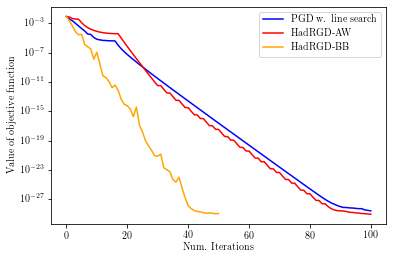

In [119]:
## Now plot the results
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.semilogy(Error_PGDL, label="PGD w. line search", color = 'blue')
plt.semilogy(AWOpt_Error, label="HadRGD-AW", color = 'red')#, marker = 'o')
plt.semilogy(BBOpt_Error, label="HadRGD-BB", color = 'orange')#, marker = 'o')
plt.legend()
plt.xlabel('Num. Iterations')
plt.ylabel('Value of objective function')
#plt.savefig('HadRGD_Lin_Convergence.pdf')
plt.show()

In [ ]:
print(step_size_PGD)

In [ ]:
print(len(np.nonzeros(z)))